In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
from helper import train_VAE 
from VAE_model import VAE
import json
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi']=200
device='cpu'

In [2]:
X_train = pd.read_csv('../../datasets/Admission/X_train.csv',index_col=0)  
X_test = pd.read_csv('../../datasets/Admission/X_test.csv',index_col=0)  
y_train = pd.read_csv('../../datasets/Admission/y_train.csv',index_col=0)  
y_test = pd.read_csv('../../datasets/Admission/y_test.csv',index_col=0) 
X_train_with_confounder=X_train.drop(columns=['CGPA'])
X_test_with_confounder=X_test.drop(columns=['CGPA'])
print(X_train.shape)
print(X_train_with_confounder)
print(X_test.shape)
print(X_test_with_confounder.shape)
print(X_train.columns)
print(X_train_with_confounder.columns)
X_train_with_confounder

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_confounder)
X_test_scaled = scaler.transform(X_test_with_confounder)


(400, 7)
     GRE Score  TOEFL Score  University Rating  SOP  LOR   Research
60         309          100                  2  3.0   3.0         0
298        330          114                  3  4.5   4.5         1
228        318          112                  3  4.0   3.5         0
141        332          118                  2  4.5   3.5         1
3          322          110                  3  3.5   2.5         1
..         ...          ...                ...  ...   ...       ...
381        319          105                  3  3.0   3.5         1
37         300          105                  1  1.0   2.0         0
153        324          105                  3  3.0   4.0         0
396        325          107                  3  3.0   3.5         1
101        312          105                  2  2.5   3.0         0

[400 rows x 6 columns]
(100, 7)
(100, 6)
Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research'],
      dtype='object')
Index(['GRE 

In [3]:
load_model="Admission_No_freeze_z_and_zz_to_y_R2_0_6899338659638417"

In [4]:
with open(f'Models/Config_{load_model}.json') as country_json1:
          config = json.load(country_json1)
          print(config)

{'config': {'x_dim': 6, 'z_dim': 3, 'zz_dim': 1, 'encoder_z_layers': [10, 10, 10], 'encoder_zz_layers': [10, 10], 'decoder_layers': [10, 10, 10, 6], 'fc_z_to_y_layers': [12, 12, 1]}, 'beta': {'b1': 10000, 'b2': 1, 'b3': 1, 'b4': 10000, 'b5': 1}, 'lr': 0.001, 'batch_size': 32, 'num_epochs': 600}


In [5]:
config_params = config['config']
beta = config['beta']
lr = config['lr']
batch_size = config['batch_size']
num_epochs = config['num_epochs']

x_dim = config_params['x_dim']
z_dim = config_params['z_dim']
zz_dim = config_params['zz_dim']
encoder_z_layers = config_params['encoder_z_layers']
encoder_zz_layers = config_params['encoder_zz_layers']
decoder_layers = config_params['decoder_layers']
fc_z_to_y_layers = config_params['fc_z_to_y_layers']
b1 = beta['b1']
b2 = beta['b2']
b3 = beta['b3']
b4 = beta['b4']
b5 = beta['b5']
model=VAE(x_dim, z_dim, zz_dim, encoder_z_layers, encoder_zz_layers, decoder_layers, fc_z_to_y_layers,z_and_zz_to_y=False)

In [6]:
train_ds = TensorDataset(torch.Tensor(X_train_scaled), torch.Tensor(y_train.to_numpy()))

test_ds = TensorDataset(torch.Tensor(X_test_scaled), torch.Tensor(y_test.to_numpy()))

In [7]:
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

In [8]:
model = torch.load(f"./Models/{load_model}_model.zip",map_location=torch.device('cpu'))
model.eval()

VAE(
  (encoder_z_seq): Sequential(
    (0): Linear(in_features=6, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
  )
  (fc21): Linear(in_features=10, out_features=3, bias=True)
  (fc22): Linear(in_features=10, out_features=3, bias=True)
  (encoder_zz_seq): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (fcz21): Linear(in_features=10, out_features=1, bias=True)
  (fcz22): Linear(in_features=10, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=6, bias

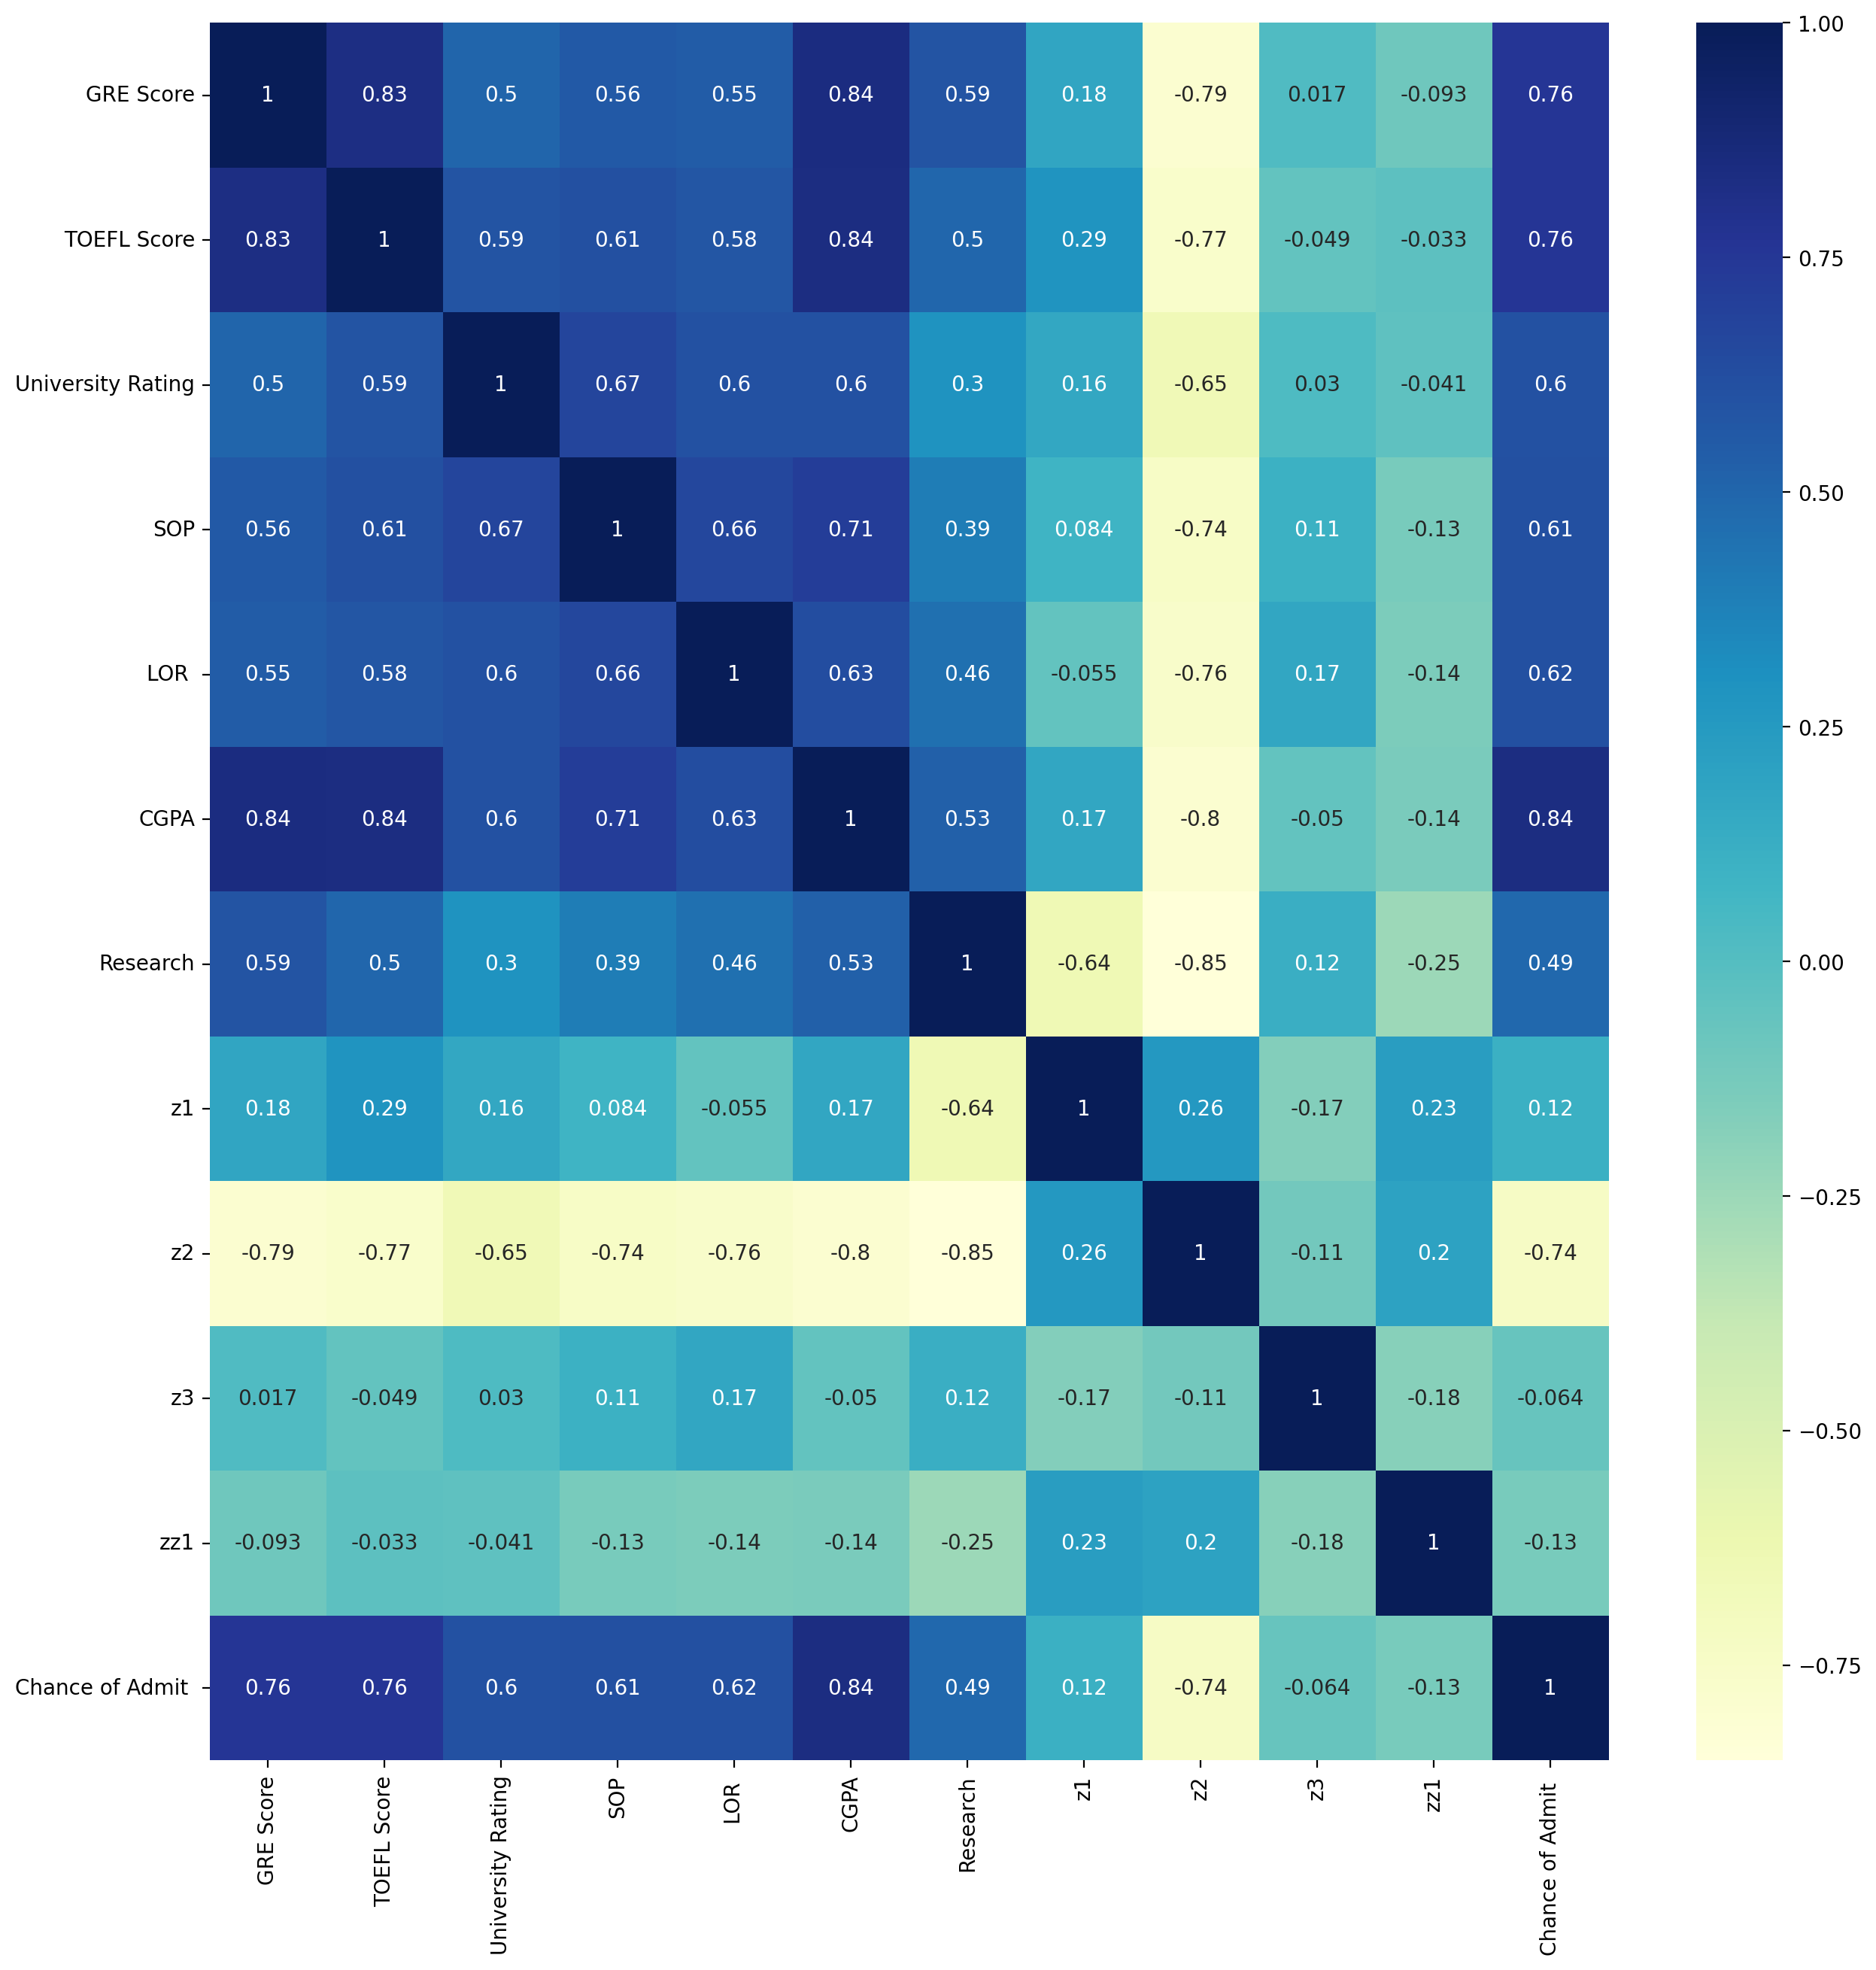

In [9]:
recon_x_subset, mu_z, log_z, mu_zz, log_zz,_ = model(torch.from_numpy(X_test_scaled).float().to(device))
# Reparameterize to get the estimated z values
z_est_subset = model.reparameterize(mu_z, log_z,1)
zz_est_subset = model.reparameterize(mu_zz, log_zz,1)


z_columns = [f'z{i+1}' for i in range(z_dim)]
zz_columns = [f'zz{i+1}' for i in range(zz_dim)]

# Convert your tensor to a dataframe
zz_est_df = pd.DataFrame(zz_est_subset.cpu().detach().numpy(), columns=zz_columns)
z_est_df = pd.DataFrame(z_est_subset.cpu().detach().numpy(), columns=z_columns)
# Reset the index of both dataframes
X_test_reset = pd.DataFrame(X_test).reset_index(drop=True)
z_est_df_reset = z_est_df.reset_index(drop=True)
zz_est_df = zz_est_df.reset_index(drop=True)
y_test_reset=  pd.DataFrame(y_test).reset_index(drop=True)


# Concatenate the dataframes
df = pd.concat([X_test_reset, z_est_df_reset,zz_est_df,y_test_reset], axis=1)

plt.figure(figsize=(15, 15))
# Compute the correlation matrix
corr = df.corr()

# Generate a heatmap
sns.heatmap(corr, cmap="YlGnBu",annot=True)
# Save the figure
#pic_name_heat = create_picture_name(config, "heatmap")
#print(pic_name_heat)
#plt.savefig(os.path.join(path, pic_name_heat))
plt.show()

In [10]:
class masked_model():
    def __init__(self, model):
        self.model = model
    
    def forward(self,x):
        _,_,_,_,_,prediction=model(x)
        return prediction

In [11]:
mod=masked_model(model)

In [12]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import random

def plot_prediction_vs_truth(model, X_s, X, y, title="Model Predictions vs Truth", num_points=300):
    device = next(model.parameters()).device

    fig, ax = plt.subplots()

    # Fetch CGPA values directly from DataFrame X
    cgpa_values = X.loc[:, 'CGPA'].values
    normalized_cgpa = (cgpa_values - np.min(cgpa_values)) / (np.max(cgpa_values) - np.min(cgpa_values))
    cmap = plt.get_cmap('coolwarm')  # Using 'coolwarm' colormap. You can choose any appropriate colormap.

    with torch.no_grad():
        model = model.eval()
        _,_,_,_,_,predictions = model(torch.tensor(X_s, dtype=torch.float, device=device))
        predictions=predictions.cpu().numpy()

    # Ensure all arrays have the same length before looping
    assert len(y) == len(X_s) == len(normalized_cgpa), "Input arrays must have the same length"
    
    indices = range(len(X_s))
    
    # Sample num_points indices
    if num_points and num_points < len(indices):
        indices = random.sample(indices, num_points)
    
    for i in indices:
        color = cmap(normalized_cgpa[i])
        plt.scatter(y.iloc[i], predictions[i], color=color, alpha=0.7)

    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)

    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.title(title)
    
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    
    # Define the colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='CGPA')

    # Customize colorbar ticks
    min_val, max_val = np.min(cgpa_values), np.max(cgpa_values)
    tick_values = np.linspace(min_val, max_val, num=6)  # 6 ticks
    normed_ticks = (tick_values - min_val) / (max_val - min_val)  # Normalize tick values (0 to 1 range)
    cbar.set_ticks(normed_ticks)
    
    # Set tick labels with two decimal places
    cbar.set_ticklabels(['{:.2f}'.format(val) for val in tick_values])

    plt.show()



In [13]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
criterion = RMSELoss()

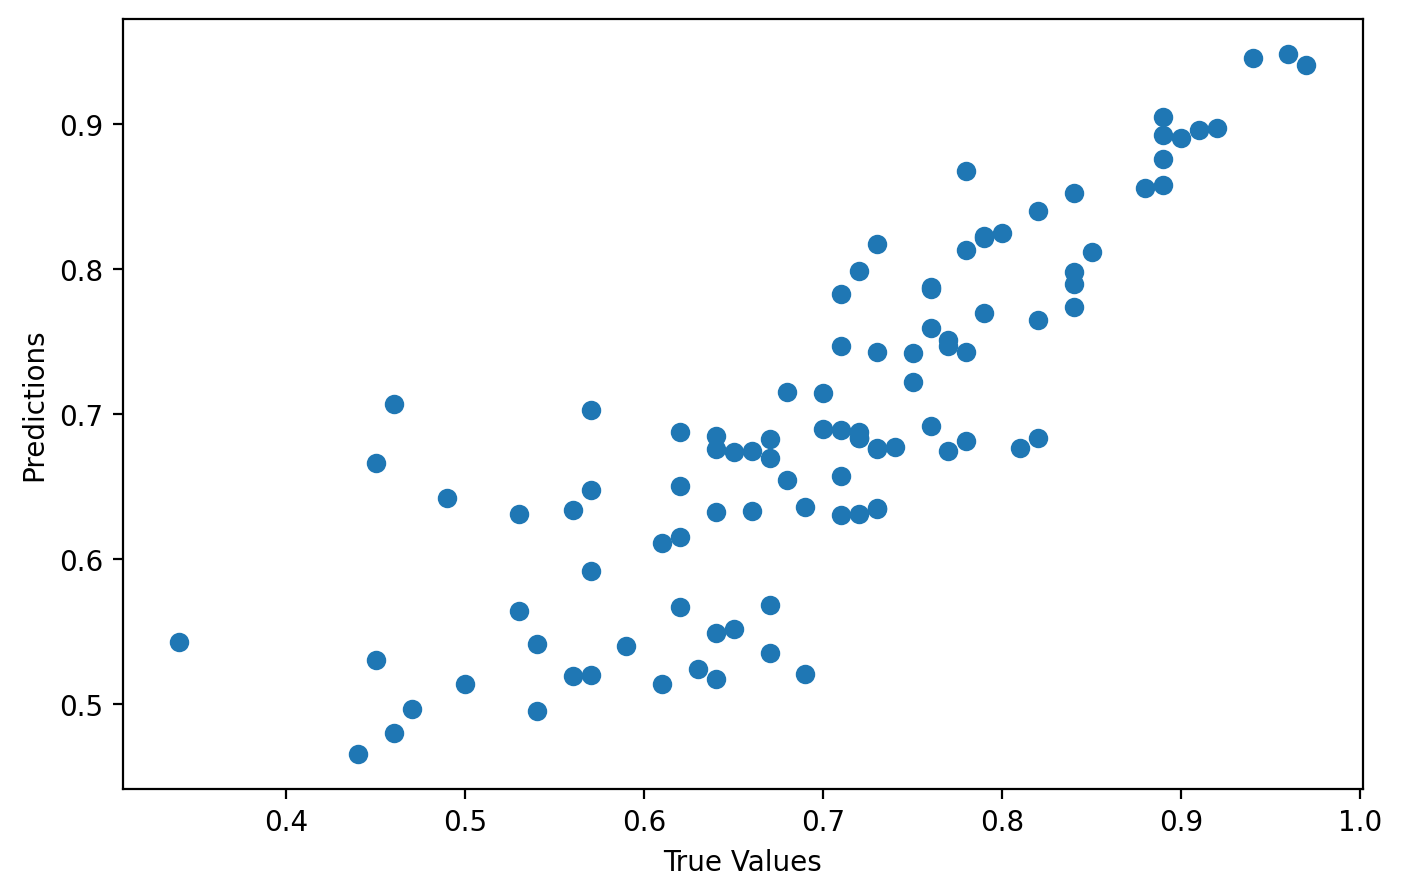

R^2 score: 0.6812864916085102
Train_loss: 0.06277331188321114
Test_loss: 0.0722140483558178


In [14]:
def plot_predictions_VAE(net, data_loader, device):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = net(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    ss_tot = np.sum((y_true - y_bar) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2
plot_predictions_VAE(mod.forward, test_loader, device)
y_true = np.array(y_test,dtype=object)

r2_Scores=0
for _ in range(10):
    y_pred = mod.forward(torch.Tensor(X_test_scaled).to(device))
    y_pred=y_pred.cpu().detach().numpy()
    r2 = r2_score(y_test, y_pred)
    r2_Scores+=r2
print("R^2 score:", r2_Scores/10)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)
trls=0
tels=0
for _ in range(10):
    trls+=criterion(mod.forward(torch.Tensor(X_train_scaled).to(device)),y_train_tensor).item()
    tels+=criterion(mod.forward(torch.Tensor(X_test_scaled).to(device)),y_test_tensor).item()
    

print("Train_loss:",trls/10)
print("Test_loss:",tels/10)


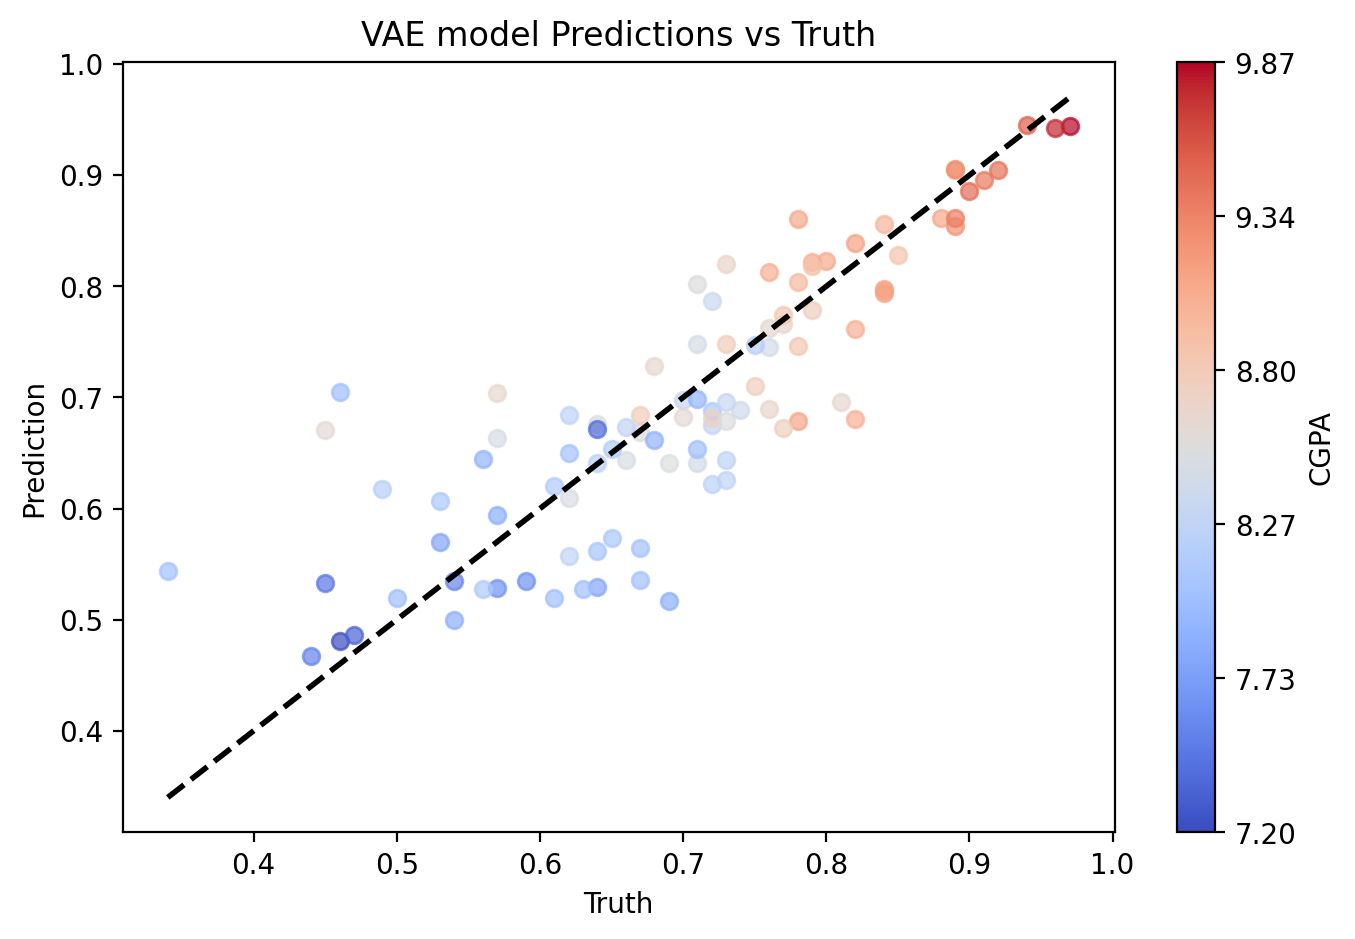

In [15]:
plot_prediction_vs_truth(model,X_test_scaled,X_test,y_test,title="VAE model Predictions vs Truth")

In [16]:
import torch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def ice_plot(model, X_s, X, y, feature_index, feature, num_points=None,off=0,num_of_rounds=5):    
    fig, ax = plt.subplots()

    # Extract the unique feature values from the unscaled data
    feature_values = pd.unique(X.iloc[:, feature_index+off].sort_values())
    feature_values_s = np.unique(np.sort(X_s[:, feature_index]))
    
    # Normalize the CGPA values for coloring
    cgpa_values = X.loc[:, 'CGPA'].values
    normalized_cgpa = (cgpa_values - np.min(cgpa_values)) / (np.max(cgpa_values) - np.min(cgpa_values))
    cmap = plt.get_cmap('coolwarm')

    # If num_points is specified, select a subset of equally spaced unique feature values
    if num_points is not None:
        idx = np.round(np.linspace(0, len(feature_values) - 1, num_points)).astype(int)
        feature_values = feature_values.iloc[idx]
        feature_values_s = feature_values_s[idx]

    
    
    XXX = X_s.copy()
    predictions_all = []

    # Loop through instances in the test set
    for instance,i in zip(XXX, range(len(X_s))):
        # Create an array to store predictions for this instance
        predictions = []
        mean_ori=0
        for _ in range(num_of_rounds):
            original_prediction = model(torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)).item()
            mean_ori+=original_prediction
        mean_ori=mean_ori/num_of_rounds

        # Loop through the unique feature values
        for val in feature_values_s:
            # Set the feature value for the current instance
            instance[feature_index] = val

            # Convert the instance to a PyTorch tensor and unsqueeze to add batch dimension
            instance_tensor = torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)

            # Get the prediction from the model
            with torch.no_grad():
                mean_pred=0
                for _ in range(num_of_rounds):
                    prediction = model(instance_tensor).item()
                    mean_pred+=prediction
                mean_pred=mean_pred/num_of_rounds
            predictions.append(mean_pred)

        predictions_all.append(predictions)

        # Plot the ICE curve for this instance in the color corresponding to CGPA value with transparency
        plt.plot(feature_values, predictions, color=cmap(normalized_cgpa[i]), alpha=0.5)
        
        # Plot the marker for the original value
        original_val = X.iloc[i, feature_index+off]
        plt.scatter(original_val, mean_ori, marker='o', color=cmap(normalized_cgpa[i]), zorder=10)

    # Calculate the mean of all ICE lines
    mean_predictions = np.mean(predictions_all, axis=0)

    # Plot the mean ICE curve in black and thicker
    plt.plot(feature_values, mean_predictions, color='black', linewidth=2)

    # Label the plot
    plt.xlabel(feature)
    plt.ylabel('Predictions')
    plt.title('ICE plot for {}'.format(feature))
    
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    
    # Define the colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='CGPA')

    # Customize colorbar ticks
    min_val, max_val = np.min(cgpa_values), np.max(cgpa_values)
    tick_values = np.linspace(min_val, max_val, num=6)  # 6 ticks
    normed_ticks = (tick_values - min_val) / (max_val - min_val)  # Normalize tick values (0 to 1 range)
    cbar.set_ticks(normed_ticks)
    
    # Set tick labels with two decimal places
    cbar.set_ticklabels(['{:.2f}'.format(val) for val in tick_values])


    # Show the plot
    plt.show()


In [72]:
import numpy as np
import matplotlib.pyplot as plt

def ice_plot_3d_single_instance(model, instance, X, X_s, feature_indices, feature_names, gridsize=50, num_of_rounds=5):
    """
    Plots a 3D ICE plot for a single instance for two features.
    
    Parameters:
    - model: The prediction model
    - instance: The instance for which to plot the ICE curves
    - X: Original unscaled data (pandas dataframe)
    - X_s: Scaled data (numpy array)
    - feature_indices: Indices of the features to use for the plot
    - feature_names: Names of the features to use for the plot
    - gridsize: Number of points to use for the grid of each feature
    - num_of_rounds: Number of rounds to average the predictions
    
    Returns:
    - None (but displays a 3D plot)
    """
    
    assert len(feature_indices) == 2, "Only two features are supported for a 3D ICE plot."
    
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Generate grids for both features
    feature_grids = [
        np.linspace(X.iloc[:, idx].min(), X.iloc[:, idx].max(), gridsize) for idx in feature_indices
    ]
    
    # Now get the corresponding scaled grids for the features
    scaled_feature_grids = [
        np.linspace(X_s[:, idx].min(), X_s[:, idx].max(), int(gridsize))
        for idx in feature_indices
    ]
    
    f1_vals, f2_vals = np.meshgrid(feature_grids[0], feature_grids[1])
    scaled_f1_vals, scaled_f2_vals = np.meshgrid(scaled_feature_grids[0], scaled_feature_grids[1])
    
    z_vals = []
    
    # Predict the model output for each grid point
    for f1, f2 in zip(scaled_f1_vals.ravel(), scaled_f2_vals.ravel()):
        instance_copy = instance.copy()
        instance_copy[feature_indices[0]], instance_copy[feature_indices[1]] = f1, f2
        
        instance_tensor = torch.tensor(instance_copy, dtype=torch.float32).unsqueeze(0)
        
        with torch.no_grad():
            mean_pred = 0
            for _ in range(num_of_rounds):
                prediction = model(instance_tensor).squeeze().item()
                mean_pred += prediction
            mean_pred = mean_pred / num_of_rounds
        z_vals.append(mean_pred)
    
    ax.plot_surface(f1_vals, f2_vals, np.array(z_vals).reshape(f1_vals.shape), cmap='viridis')
    
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel('Prediction')
    ax.view_init(elev=12, azim=165)
    plt.show()

# Usage:
# sample_instance = X_test_scaled[11]


[[308.  110.    3.    3.5   3.    1. ]]


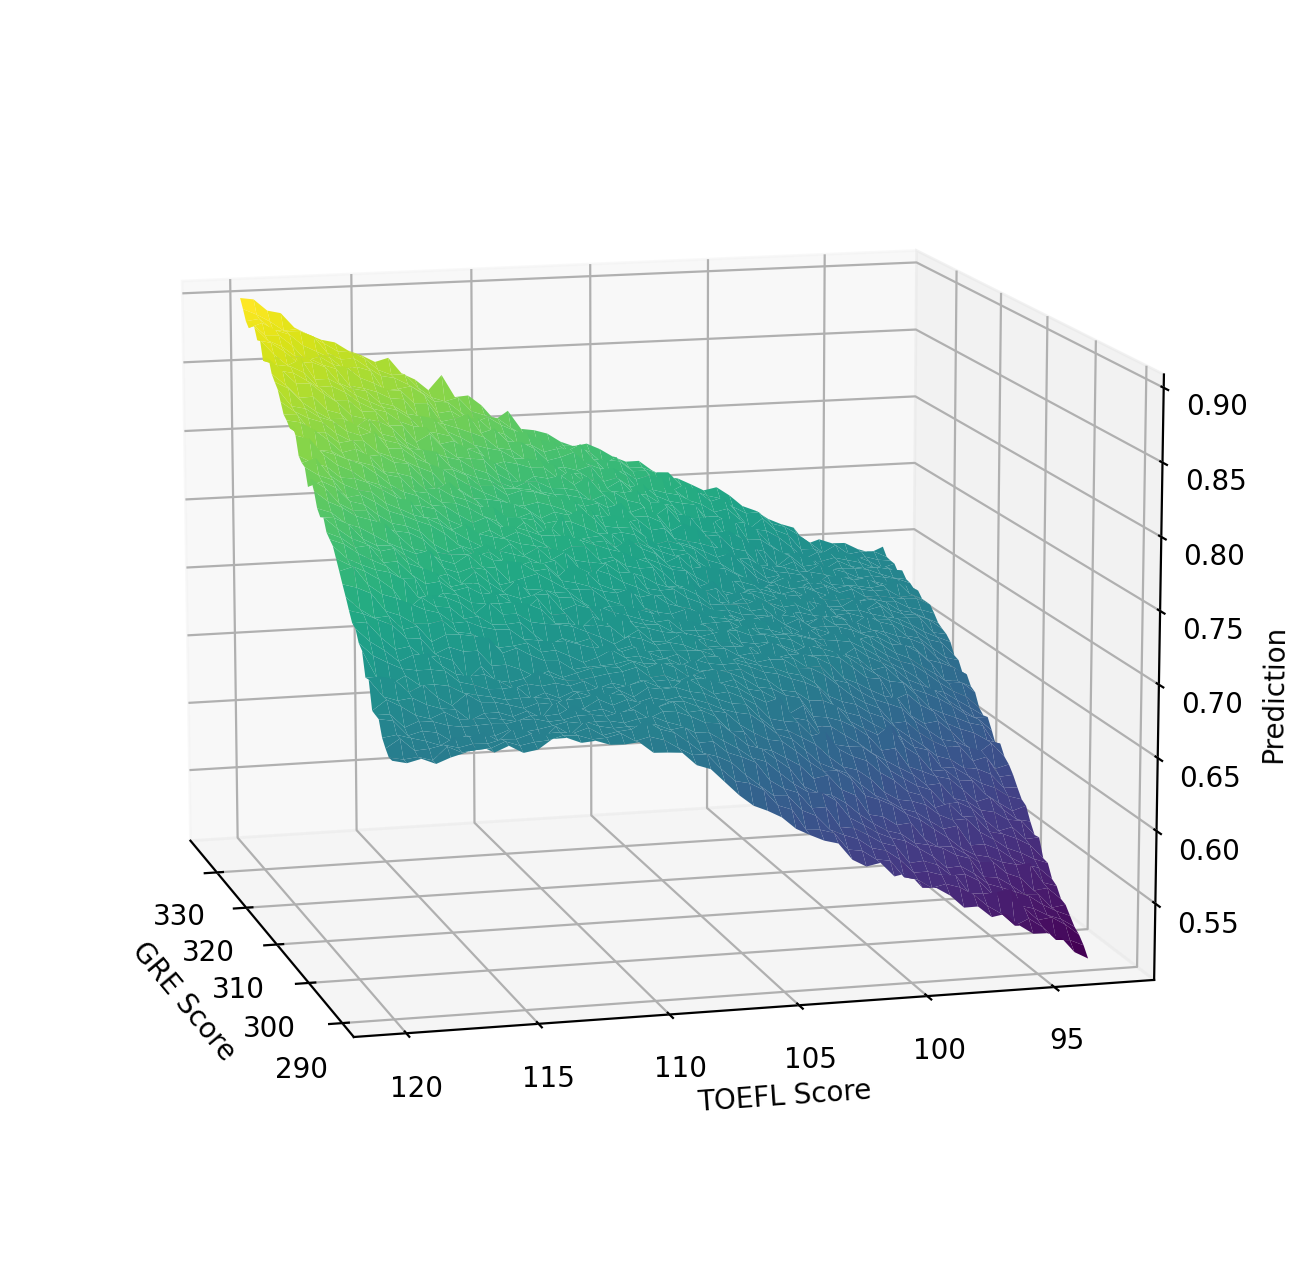

In [73]:
#ice_plot_3d(mod.forward, X_test_scaled, X_test, y_test,[0,1],['GRE Score','TOEFL Score'],num_of_rounds=1)
# Just a placeholder example. Replace with your actual instance and data.
sample_instance = X_test_scaled[4]
print(scaler.inverse_transform(sample_instance.reshape(1, -1)))
ice_plot_3d_single_instance(mod.forward, sample_instance ,X_test,X_test_scaled, [0, 1], ['GRE Score', 'TOEFL Score'],num_of_rounds=10)


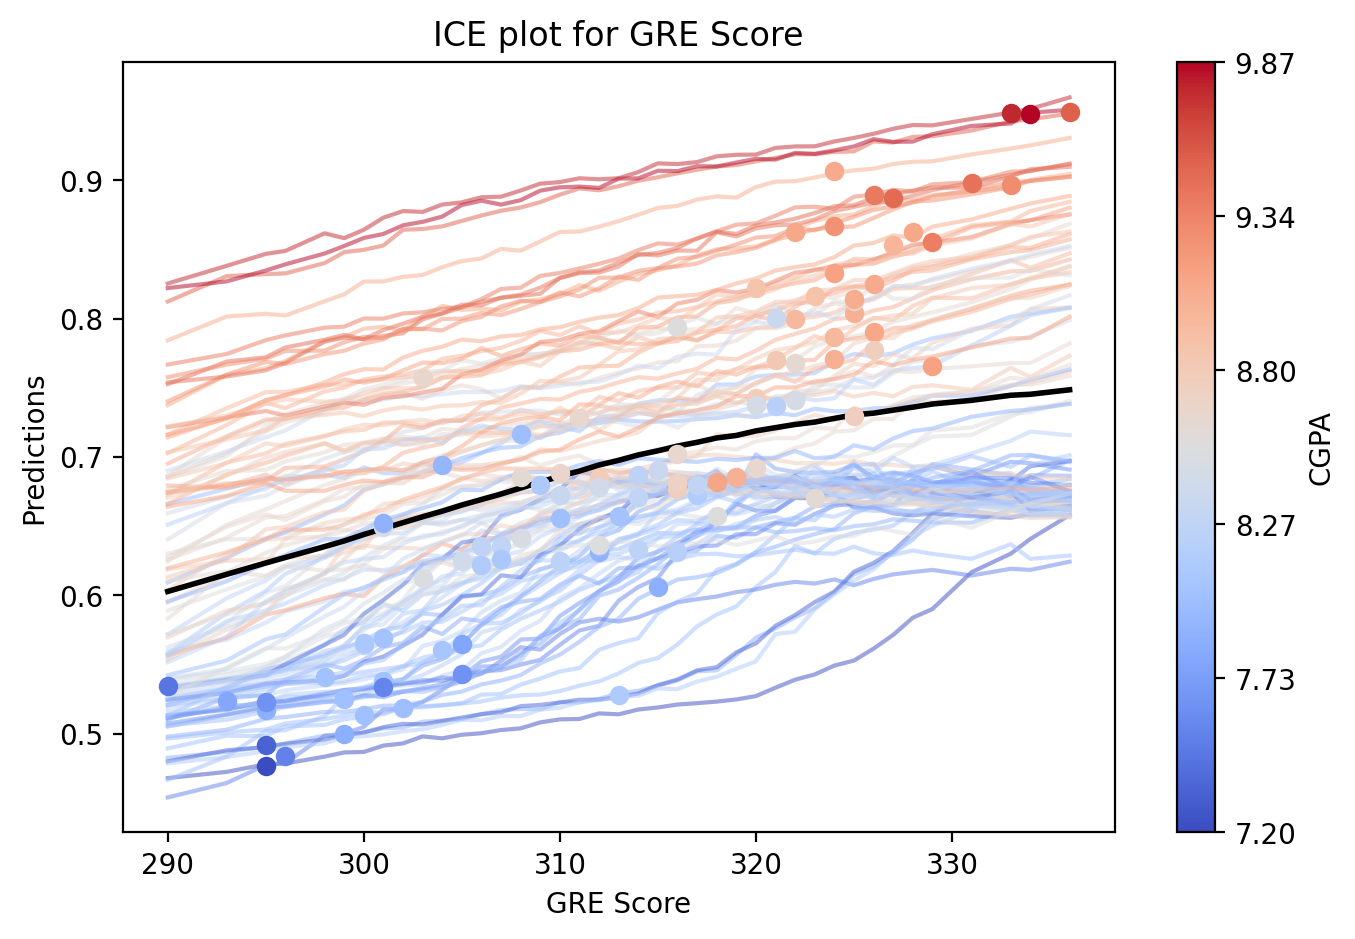

In [67]:
ice_plot(mod.forward, X_test_scaled, X_test, y_test,0, 'GRE Score',num_of_rounds=10)

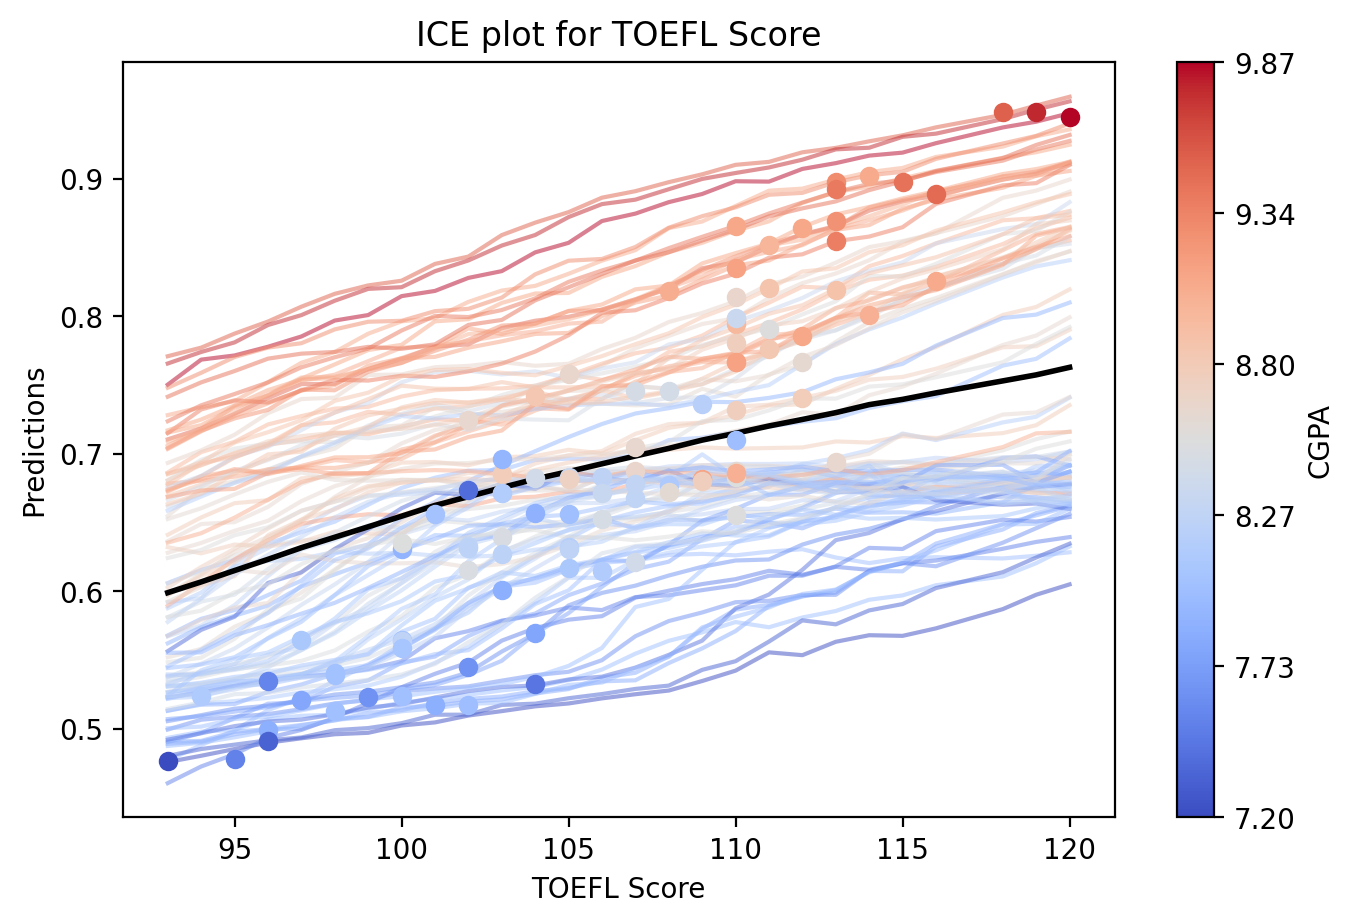

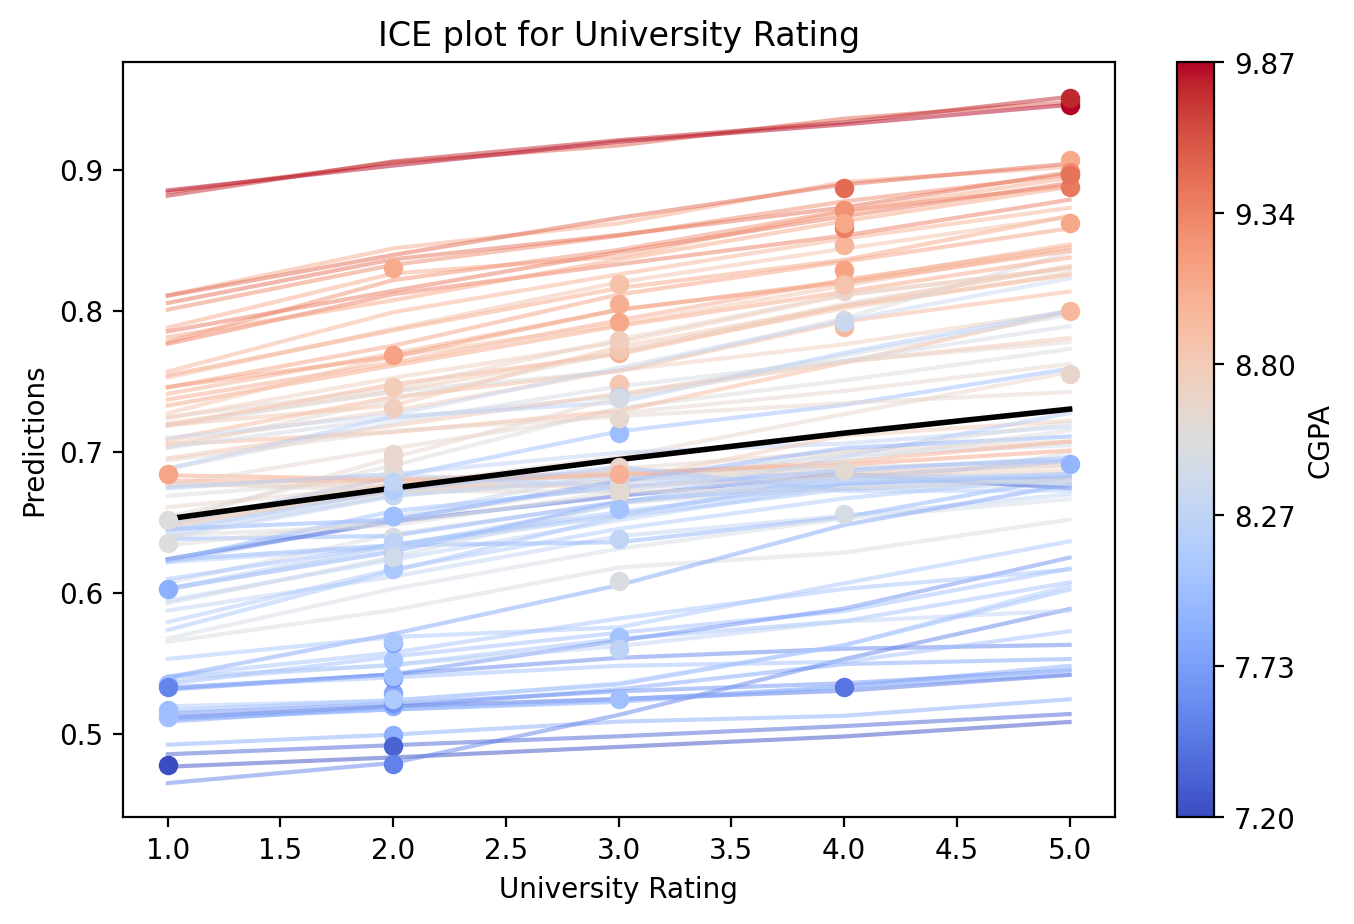

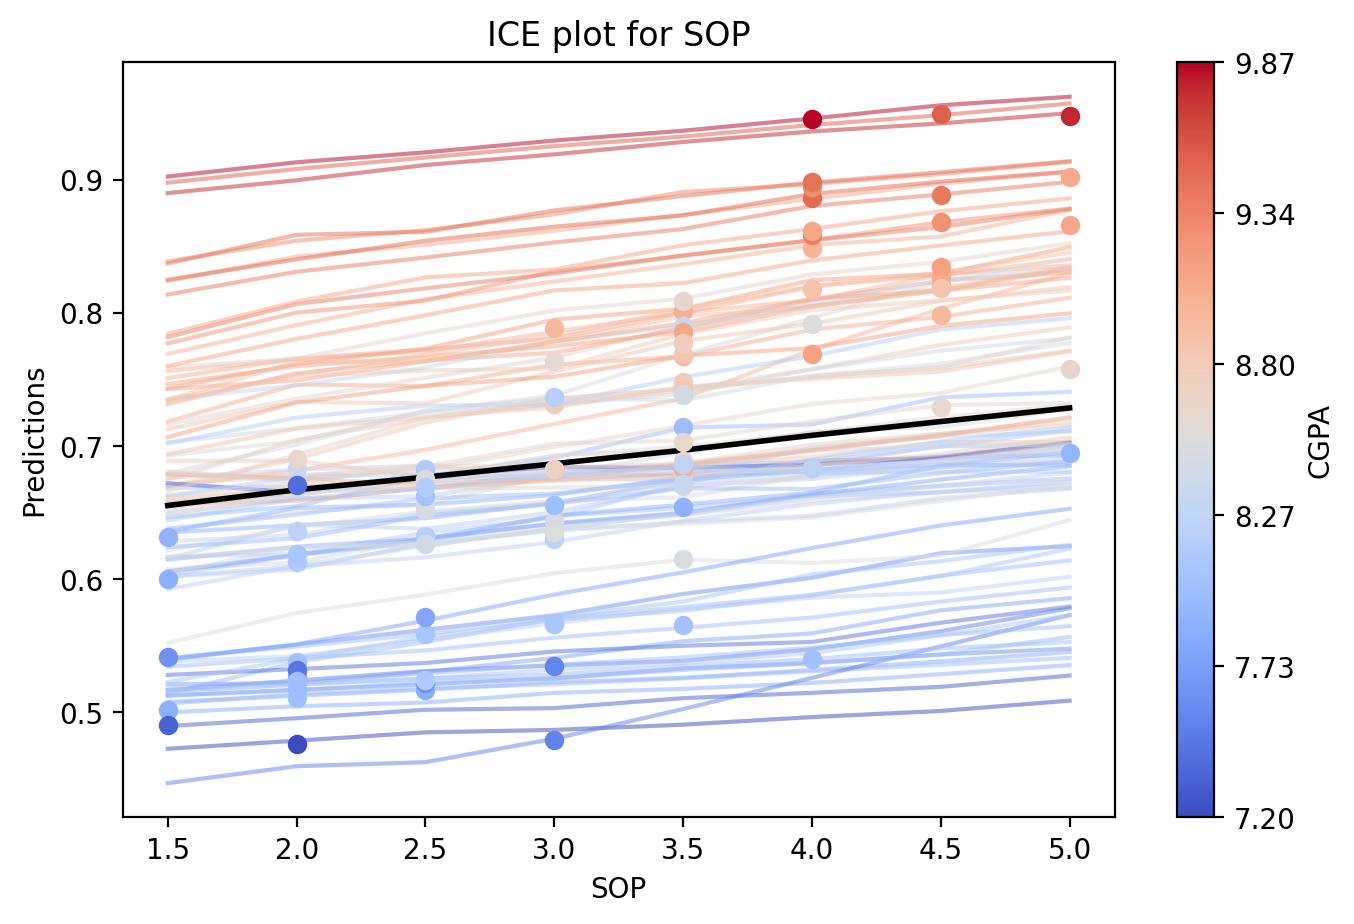

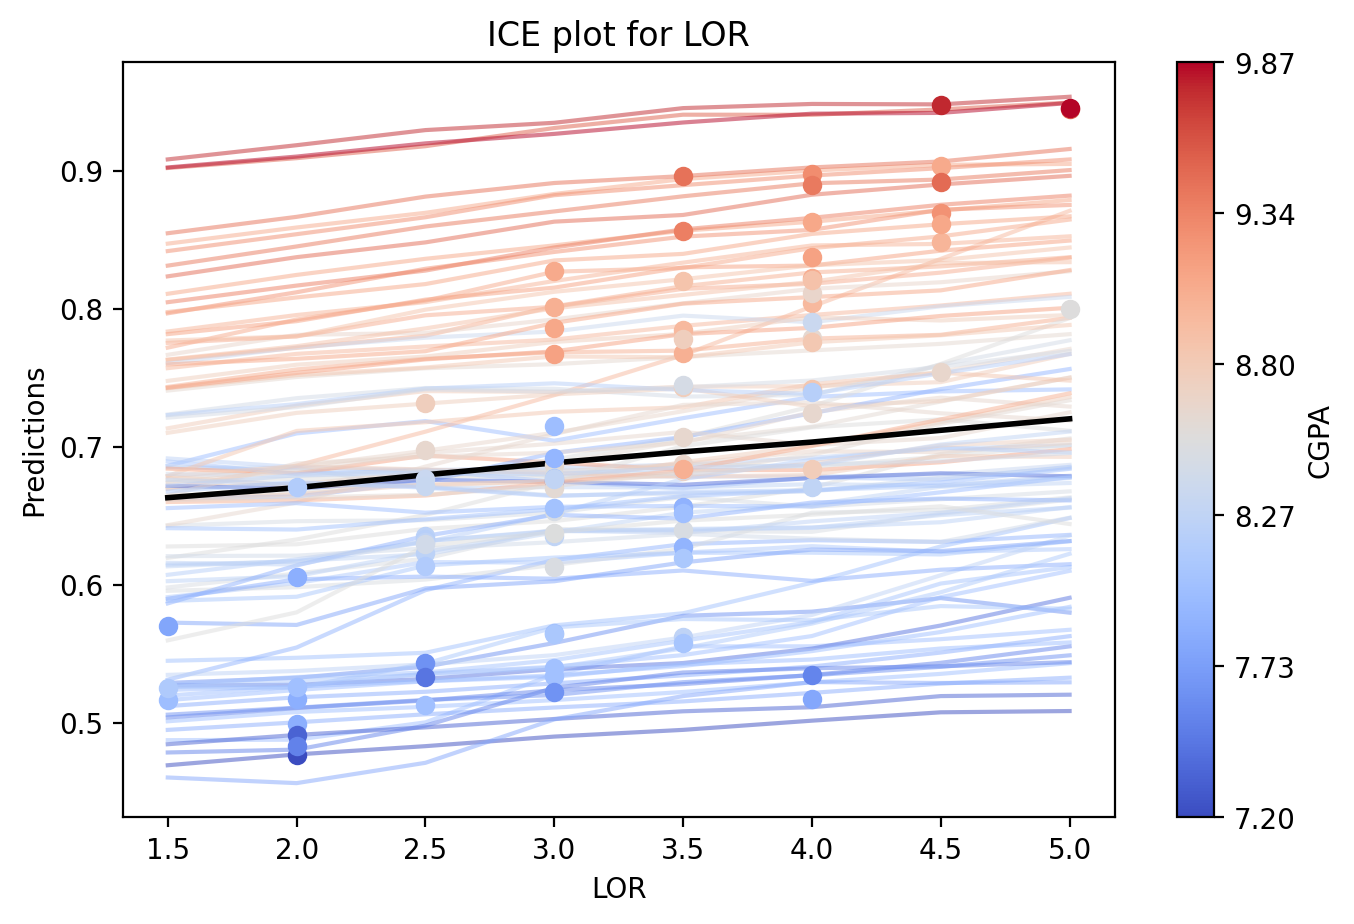

In [120]:
ice_plot(mod.forward, X_test_scaled, X_test, y_test,1,'TOEFL Score',num_of_rounds=10)
ice_plot(mod.forward, X_test_scaled, X_test, y_test,2, 'University Rating',num_of_rounds=10)
ice_plot(mod.forward, X_test_scaled, X_test, y_test,3, 'SOP',num_of_rounds=10)
ice_plot(mod.forward, X_test_scaled, X_test, y_test,4, 'LOR',num_of_rounds=10)

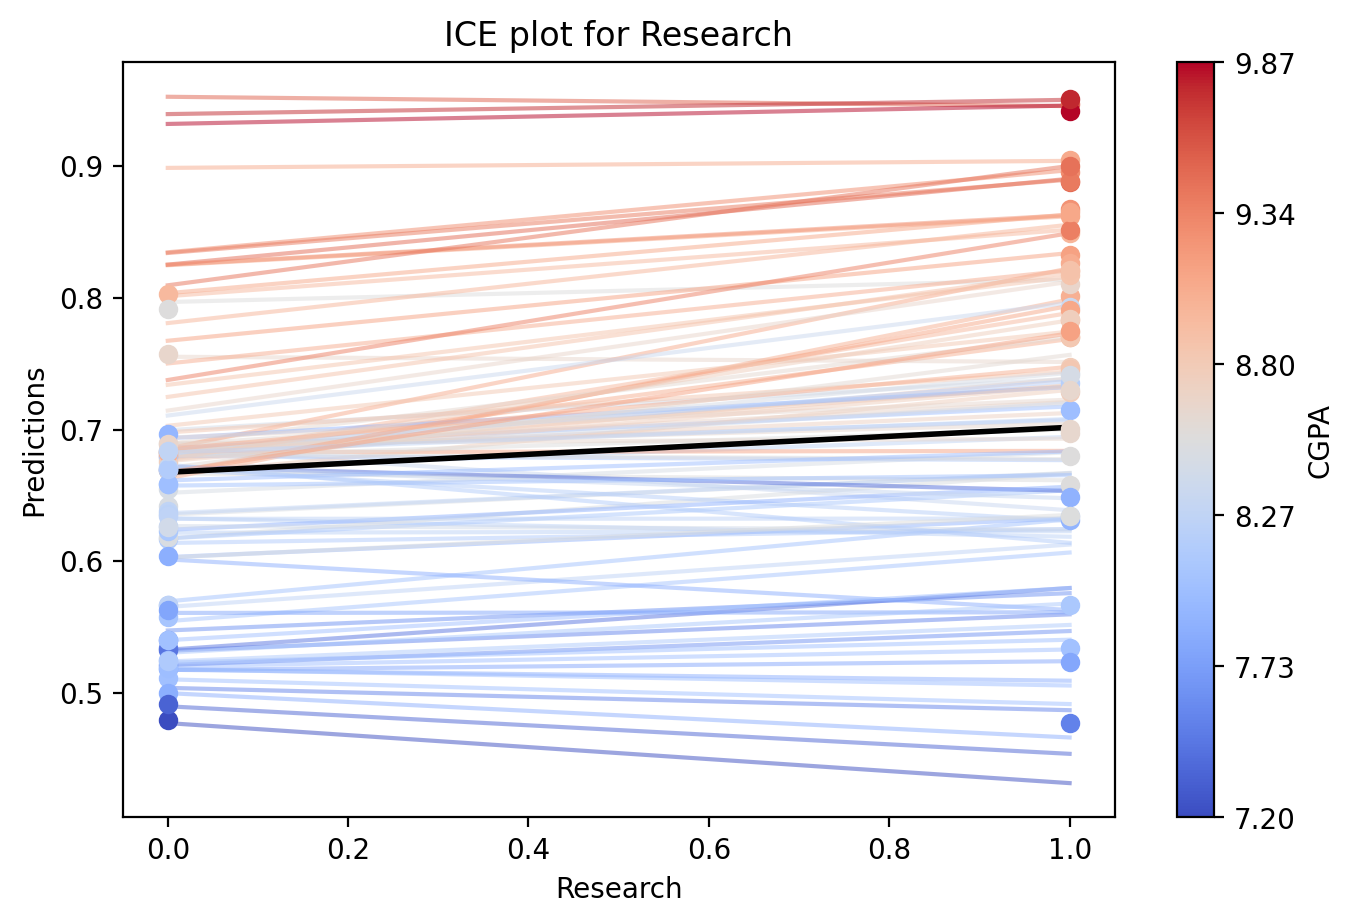

In [121]:
ice_plot(mod.forward, X_test_scaled, X_test, y_test, 5, 'Research',off=1,num_of_rounds=10)

In [74]:
class masked_model():
    def __init__(self, model):
        self.model = model
    
    def forward(self,x):
        _,_,_,_,_,prediction=model(x)
        return prediction

In [75]:
mod=masked_model(model)

In [76]:
num_runs=100

In [77]:
y_test_series = y_test.iloc[:, 0]
X_test_scaled[y_test_series.argmin()]
worst_instance = torch.tensor(X_test_scaled[y_test_series.argmin()]).unsqueeze(0).float().to(device)
best_instance = torch.tensor(X_test_scaled[y_test_series.argmax()]).unsqueeze(0).float().to(device)
#median_instance = torch.tensor(X_test_scaled[median_index]).unsqueeze(0).float().to(device)

baseline = torch.tensor(X_test_scaled.mean(axis=0)).unsqueeze(0).float().to(device)
avg_worst=0
avg_best=0
avg_base=0
for _ in range(num_runs):
    avg_worst+=mod.forward(worst_instance)
    avg_best+=mod.forward(best_instance)
    avg_base+=mod.forward(baseline)
avg_worst=avg_worst/num_runs
avg_best=avg_best/num_runs
avg_base=avg_base/num_runs
print(avg_worst)
print(avg_best)
print(avg_base)

tensor([[0.5401]], grad_fn=<DivBackward0>)
tensor([[0.9473]], grad_fn=<DivBackward0>)
tensor([[0.7058]], grad_fn=<DivBackward0>)


In [83]:
X_test.iloc[y_test_series.argmin()]

GRE Score            298.00
TOEFL Score           98.00
University Rating      2.00
SOP                    4.00
LOR                    3.00
CGPA                   8.03
Research               0.00
Name: 92, dtype: float64

In [86]:
y_test_series.min()

0.34

In [84]:
X_test.iloc[y_test_series.argmax()]

GRE Score            334.00
TOEFL Score          120.00
University Rating      5.00
SOP                    4.00
LOR                    5.00
CGPA                   9.87
Research               1.00
Name: 203, dtype: float64

In [87]:
y_test_series.max()

0.97

In [89]:
baseline = torch.tensor(X_test.mean(axis=0)).unsqueeze(0).float().to(device)
baseline

tensor([[313.9100, 106.2600,   2.8400,   3.2100,   3.2800,   8.4815,   0.4800]])

In [90]:
X_test.mean(axis=0)

GRE Score            313.9100
TOEFL Score          106.2600
University Rating      2.8400
SOP                    3.2100
LOR                    3.2800
CGPA                   8.4815
Research               0.4800
dtype: float64

In [133]:
# Instantiate KernelShap
ks = KernelShap(mod.forward)
num_runs = 100

# Initialize accumulators to zero
cumulative_worst_shap_values = 0
cumulative_best_shap_values = 0
cumulative_baseline_shap_values = 0

for _ in range(num_runs):
    cumulative_worst_shap_values += ks.attribute(worst_instance, baseline, n_samples=200)
    cumulative_best_shap_values += ks.attribute(best_instance, baseline, n_samples=200)
    #cumulative_baseline_shap_values += ks.attribute(baseline, baseline, n_samples=30000)

# Calculate the average by dividing by the number of runs
average_worst_shap_values = cumulative_worst_shap_values / num_runs
average_best_shap_values = cumulative_best_shap_values / num_runs
#average_baseline_shap_values = cumulative_baseline_shap_values / num_runs

In [127]:
import shap
import numpy as np
def shap_vis(values,baseline_shap_values,data,feature_names):
    print(values)
    print(baseline_shap_values)
    print(data)

    # define the corresponding SHAP values
    shap_values = values

    # get the index of the baseline value
    baseline_index = np.argmin(np.abs(shap_values))

    # get the baseline value
    baseline_value = baseline_shap_values

    # create a SHAP Explanation object
    expl = shap.Explanation(values=shap_values,
                        base_values=baseline_value,
                        data=data,
                        feature_names=feature_names)

    # create a SHAP waterfall plot
    shap.plots.waterfall(expl)

    shap.plots.force(expl)

[ 0.0616449   0.1049496   0.0462967   0.01842434  0.01612772 -0.00581456]
0.7054538726806641
GRE Score            334.0
TOEFL Score          120.0
University Rating      5.0
SOP                    4.0
LOR                    5.0
Research               1.0
Name: 203, dtype: float64


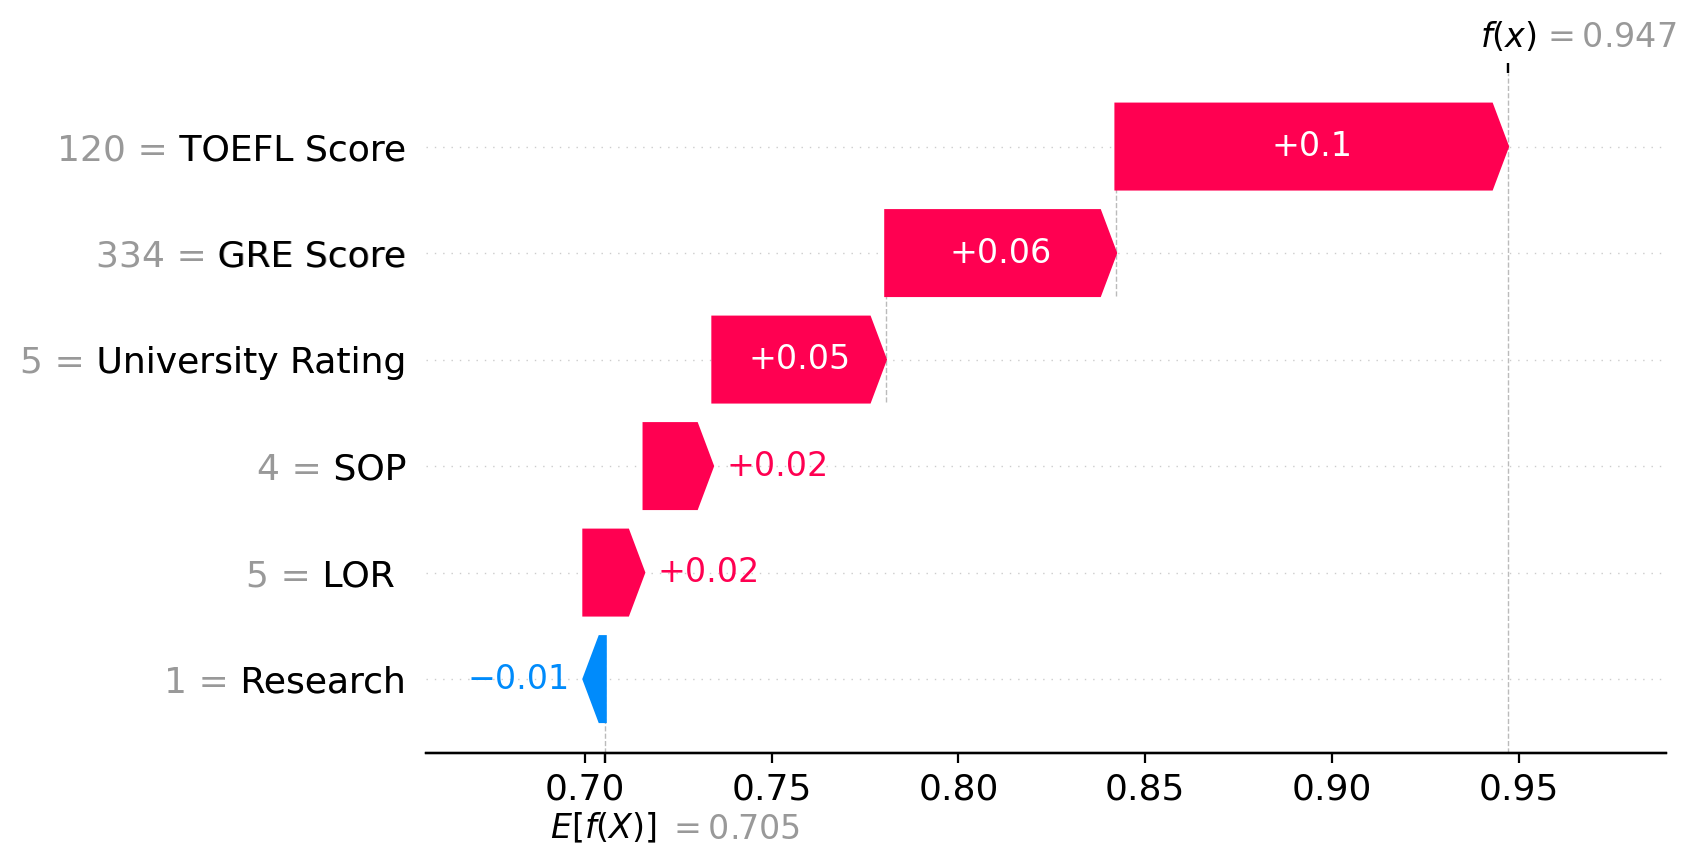

In [139]:
shap_vis(average_best_shap_values[0],avg_base.item(),X_test_with_confounder.iloc[y_test_series.argmax()],X_test_with_confounder.columns)

[-0.08915663 -0.07463885 -0.01811041  0.02057226 -0.00734482  0.00425992]
0.7054538726806641
GRE Score            298.0
TOEFL Score           98.0
University Rating      2.0
SOP                    4.0
LOR                    3.0
Research               0.0
Name: 92, dtype: float64


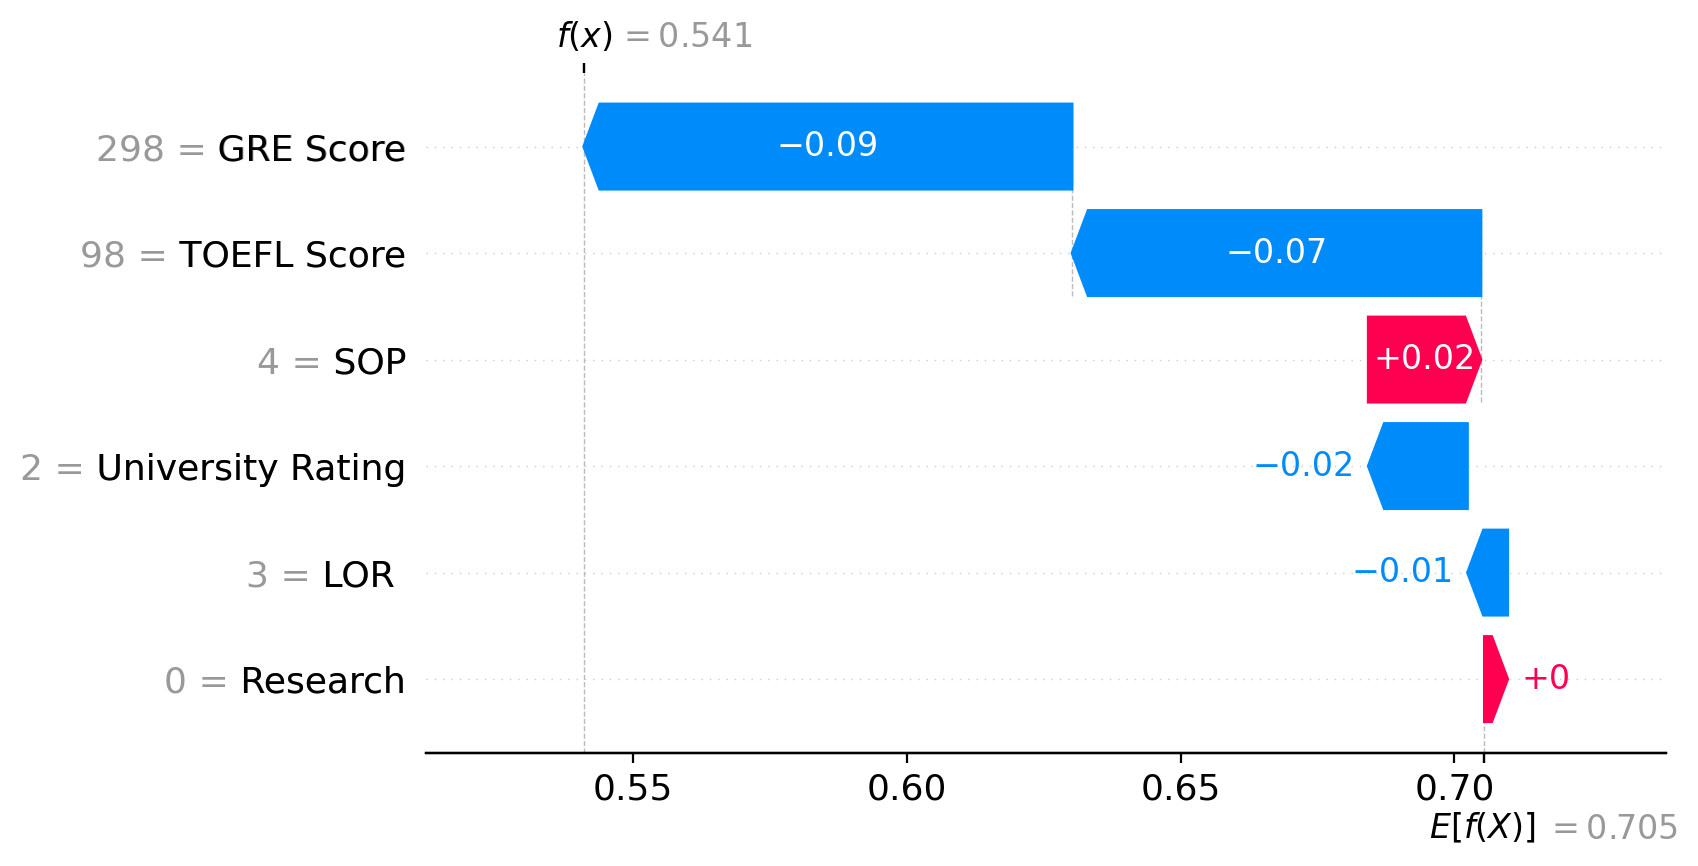

In [140]:
shap_vis(average_worst_shap_values[0],avg_base.item(),X_test_with_confounder.iloc[y_test_series.argmin()],X_test_with_confounder.columns)

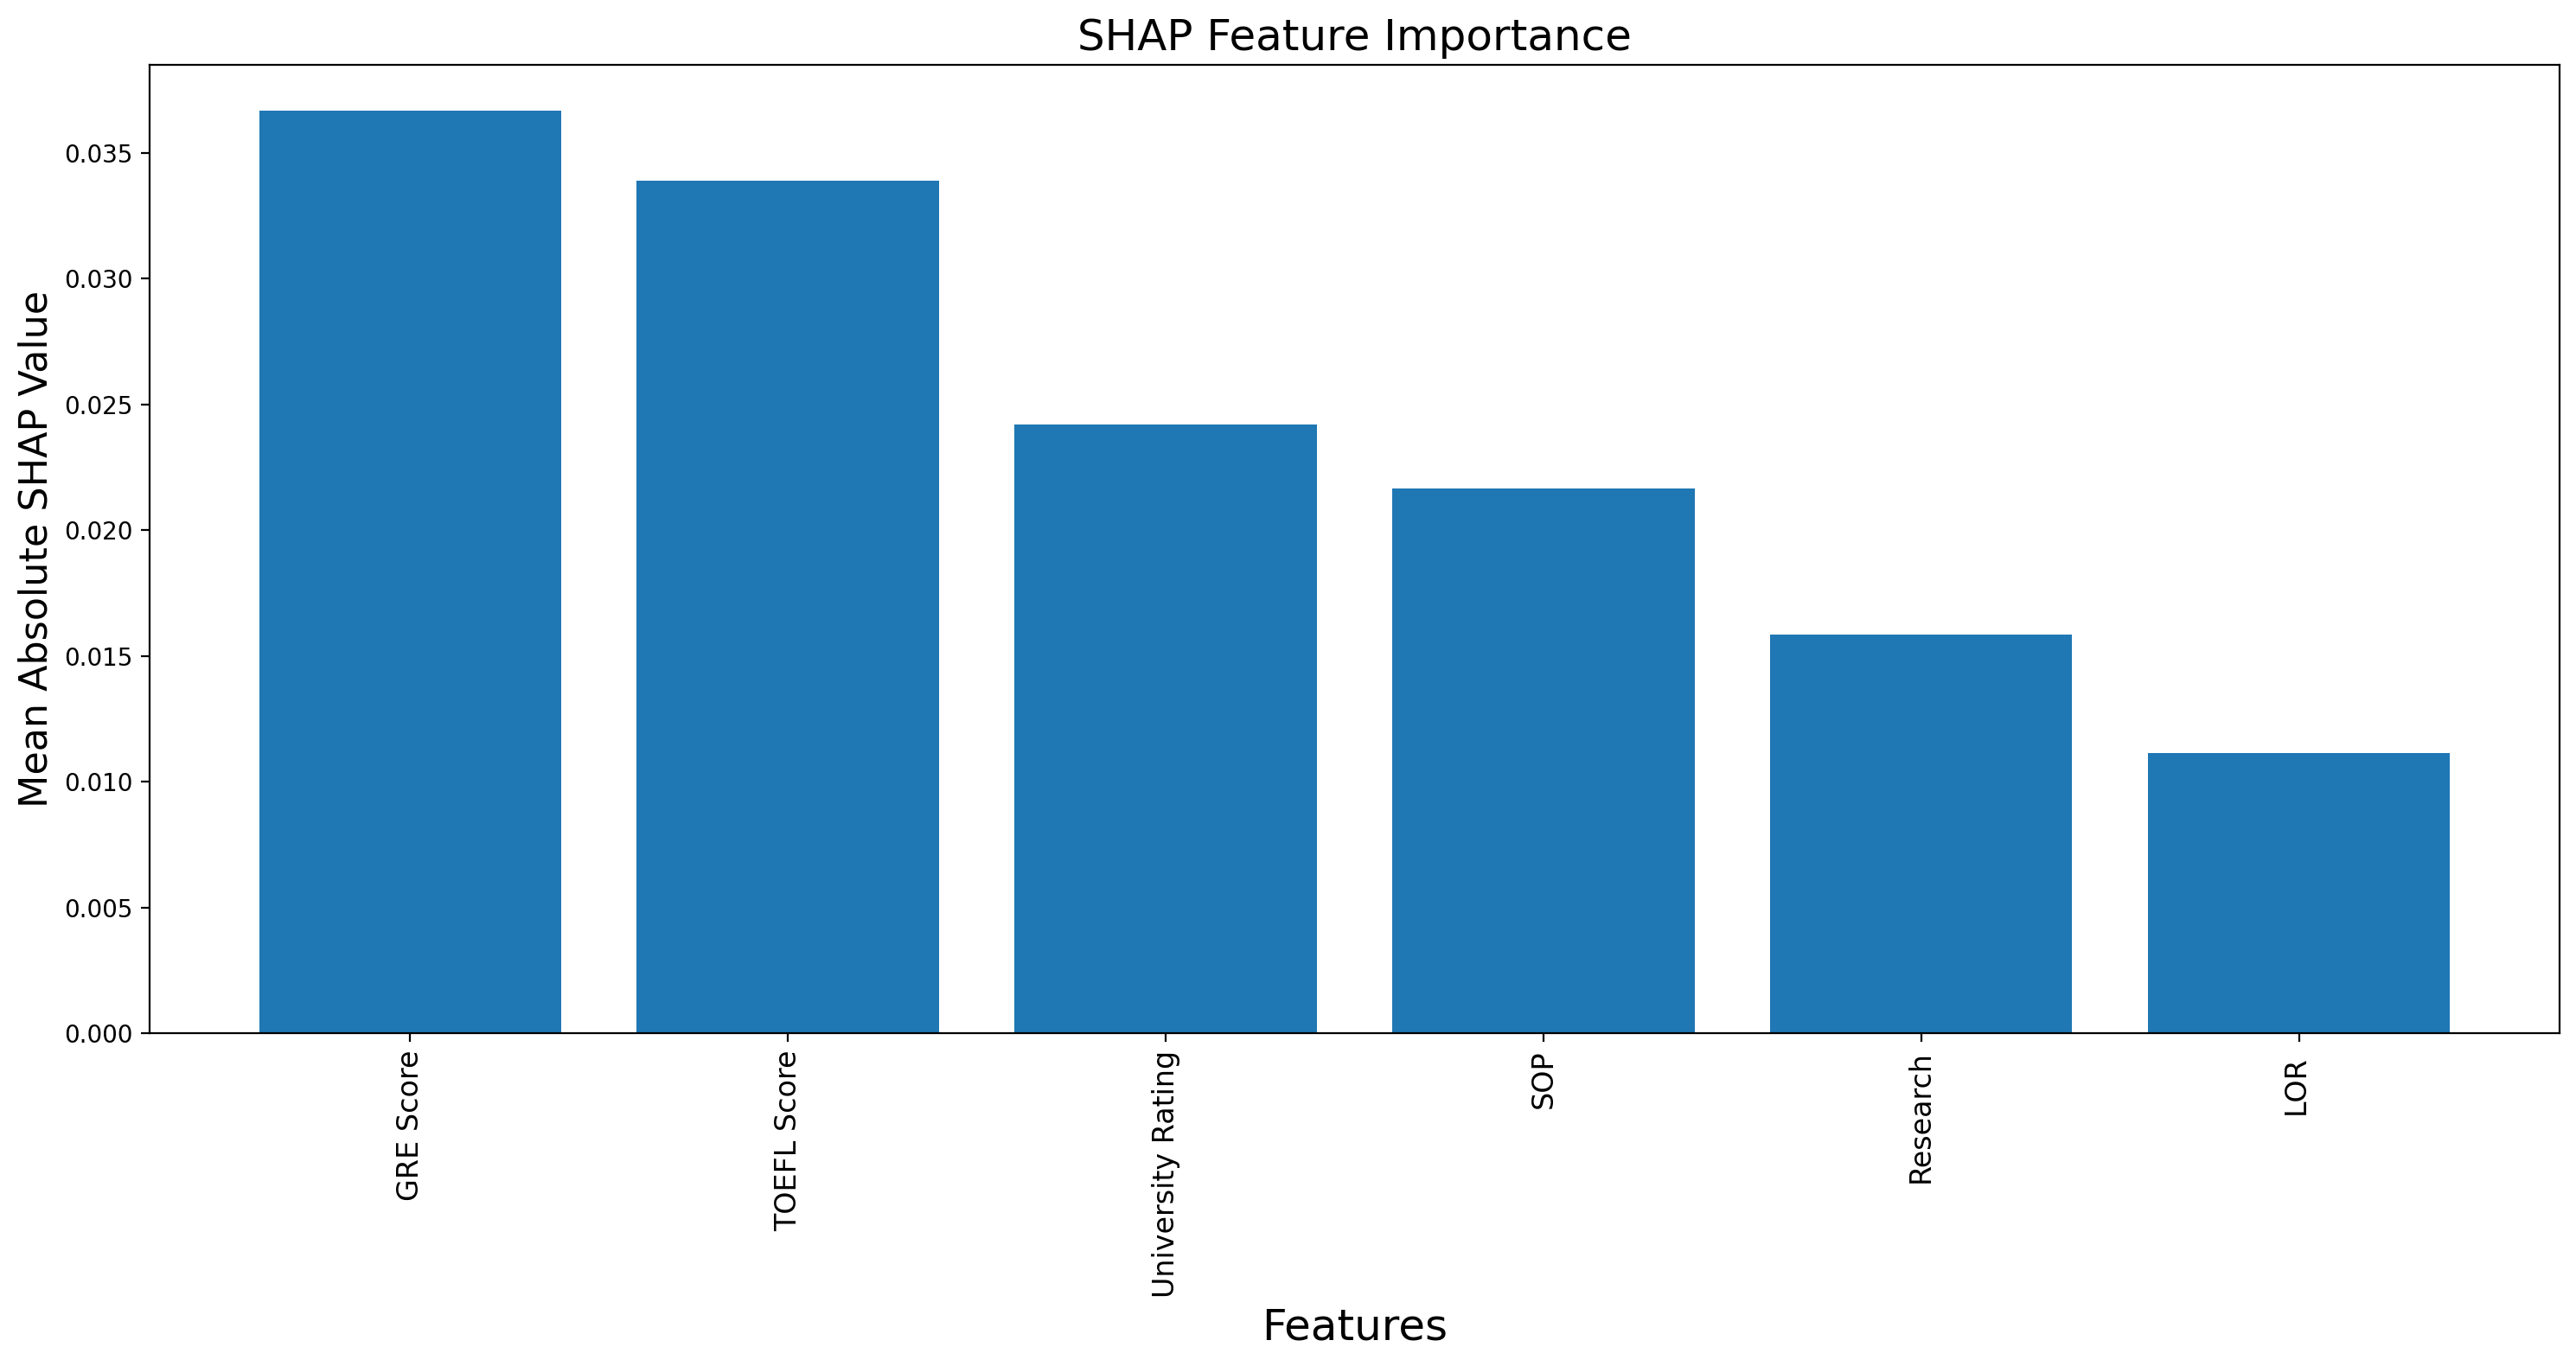

In [130]:
import torch
import numpy as np
from captum.attr import KernelShap
import matplotlib.pyplot as plt

# Instantiate KernelShap
sk = KernelShap(mod.forward)

# Prepare your dataset
# Here, let's assume X_train is your entire dataset
# And that it's a PyTorch Tensor

X_test_t = torch.from_numpy(X_test_scaled)  
# Attribute SHAP values
global_shap_values = []

r_g=5
for instance in X_test_t:
    global_cumulative_shap_values = 0
    for _ in range(r_g):
        shap_values = sk.attribute(instance.unsqueeze(0).float().to(device), baseline,n_samples=200)
        global_cumulative_shap_values+=shap_values
    global_mean_shap_values=global_cumulative_shap_values/r_g
    global_shap_values.append(global_mean_shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])

# Compute the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(global_shap_values), axis=0)

# Sort features by their importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = X_test_with_confounder.columns[sorted_indices]

# Plot the SHAP feature importance
plt.figure(figsize=(15, 8),dpi=200)
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.title('SHAP Feature Importance',fontsize=18)
plt.xlabel('Features',fontsize=18)
plt.ylabel('Mean Absolute SHAP Value',fontsize=16)
plt.xticks(rotation=90,fontsize=12)
plt.tight_layout()
plt.show()


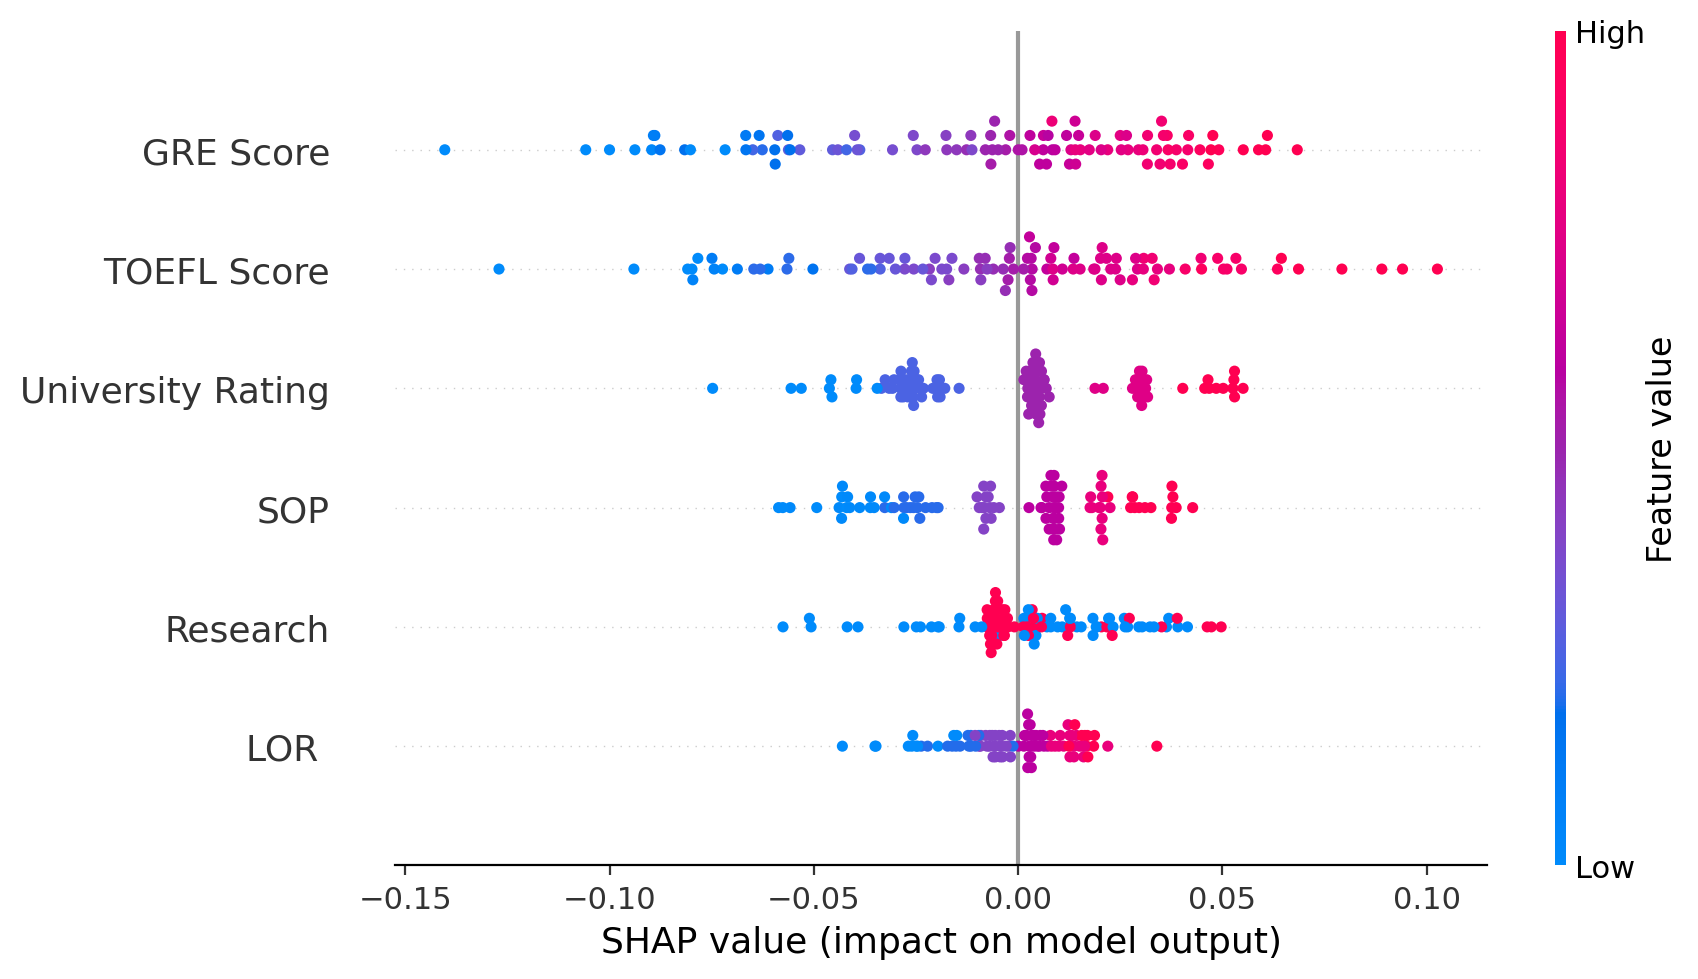

In [131]:
import shap

# Convert the global_shap_values back to a format that shap.summary_plot can understand
global_shap_values = global_shap_values.reshape(global_shap_values.shape[0], -1)

# Create a SHAP summary plot
shap.summary_plot(global_shap_values, X_test_scaled, feature_names=X_test_with_confounder.columns,plot_size=(9,5))
